In [1]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from graphviz import Digraph
from joblib import Parallel, delayed
from scipy import stats

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter

import survivors.datasets as ds

import cProfile
import pstats

%load_ext line_profiler
%load_ext scalene

Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.


In [160]:
a = np.array([1, 2, 3, 4, 5])
b = np.array([0.1, 0.9, 0.8, 0.4, 0.5])

sf = np.array([[[0.5, 0.1, 0.05],
                [0.6, 0.1, 0.05],
                [0.7, 0.1, 0.05],
                [0.8, 0.1, 0.05],
                [0.9, 0.1, 0.05]],
               [[0.5, 0.2, 0.0],
                [0.6, 0.2, 0.0],
                [0.7, 0.2, 0.0],
                [0.8, 0.2, 0.0],
                [0.9, 0.2, 0.0]]])

# sf = np.array([[[0.5],
#                 [0.6],
#                 [0.7],
#                 [0.8],
#                 [0.9],
#                [[0.1],
#                 [0.2],
#                 [0.3],
#                 [0.4],
#                 [0.5]]]])

sf = np.array([[0.5, 0.6, 0.7, 0.8, 0.9],
               [0.1, 0.2, 0.3, 0.4, 0.5]])

weights = np.vstack([a, b]).T
print(sf.shape, weights.shape)
np.sum((sf.T*weights).T, axis=0) / np.sum(weights, axis=1).reshape(-1, 1)

(2, 5) (5, 2)


array([[0.46363636, 1.25454545, 2.12727273, 3.05454545, 4.31818182],
       [0.17586207, 0.47586207, 0.80689655, 1.15862069, 1.63793103],
       [0.13421053, 0.36315789, 0.61578947, 0.88421053, 1.25      ],
       [0.11590909, 0.31363636, 0.53181818, 0.76363636, 1.07954545],
       [0.09272727, 0.25090909, 0.42545455, 0.61090909, 0.86363636]])

In [150]:
np.mean(weights, axis=0)

array([3.  , 0.54])

In [156]:
np.sum((sf.T*weights).T, axis=0) / np.sum(weights, axis=1).reshape(-1, 1)

array([[0.5       , 0.10909091, 0.04545455],
       [0.6       , 0.13103448, 0.03448276],
       [0.7       , 0.12105263, 0.03947368],
       [0.8       , 0.10909091, 0.04545455],
       [0.9       , 0.10909091, 0.04545455]])

In [118]:
np.dot(sf.T, weights.T).shape

(3, 5, 5)

In [122]:
sf.T.shape

(3, 5, 2)

In [121]:
(weights @ sf)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 5 is different from 2)

In [141]:
np.tensordot(weights.T, sf.T, axes=0).shape

(2, 5, 3, 5, 2)

In [210]:
from survivors.tree import CRAID

class IBSCRAID(CRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.ibs_leaf = None
        
    def set_ibs_by_leaf(self, X, y):
        numbs = self.predict(X, target="numb").astype("int")
        sf = self.predict_at_times(X, self.bins, mode="surv")
        ibs_v = metr.ibs(y, y, sf, self.bins, axis=0)

        counts = np.bincount(numbs)
        self.ibs_leaf = np.bincount(numbs, weights=ibs_v)
        self.ibs_leaf[counts>0]/=counts[counts>0]
        self.ibs_mean = np.mean(ibs_v)
    
    def get_ibs_by_leaf(self, X, divide=False):
        numbs = self.predict(X, target="numb").astype("int")
        if divide:
            return self.ibs_leaf[numbs] / self.ibs_mean
        return self.ibs_leaf[numbs]
    
    def fit(self, X, y):
        super().fit(X, y)
        self.set_ibs_by_leaf(X, y)

In [378]:
a = np.array([[1, 0.5, 0.3],
          [2, 0.8, 0.1],
          [3, 0.2, 0.9]])
(a - np.array([0, 1, 2])) / np.array([1, 2, 4])

array([[ 1.   , -0.25 , -0.425],
       [ 2.   , -0.1  , -0.475],
       [ 3.   , -0.4  , -0.275]])

In [412]:
from survivors.ensemble import BoostingCRAID
from scipy.stats import norm

class IBSBoostingCRAID(BoostingCRAID):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.name = "IBSBoostingCRAID"
    
    def fit(self, X, y):
        self.features = X.columns
        X = X.reset_index(drop=True)
        X[cnt.CENS_NAME] = y[cnt.CENS_NAME].astype(np.int32)
        X[cnt.TIME_NAME] = y[cnt.TIME_NAME].astype(np.float32)
        
        self.X_train = X
        self.X_train["ind_start"] = self.X_train.index
        self.y_train = y
        
        self.weights = np.zeros(self.X_train.shape[0], dtype=float)
        self.bettas = []
        self.l_weights = []
        self.ibs_means = []
        self.ibs_stds = []
        self.update_params()
        
        for i in range(self.n_estimators):
            if self.with_arc:
                prob_weights = arc_x4(self.weights)
            else:
                prob_weights = self.weights
            if i == 0:
                self.ibs_means.append(0.0)
                self.ibs_stds.append(1.0)
            else:
                self.ibs_means.append(np.mean(self.weights))
                self.ibs_stds.append(np.std(self.weights))
            prob_weights = norm.cdf((self.weights - self.ibs_means[-1]) / self.ibs_stds[-1])
                
            x_sub = self.X_train.sample(n=self.size_sample, weights=prob_weights,  # self.weights
                                        replace=self.bootstrap, random_state=i)
            x_oob = self.X_train.loc[self.X_train.index.difference(x_sub.index), :]

            x_sub = x_sub.reset_index(drop=True)
            X_sub_tr, y_sub_tr = cnt.pd_to_xy(x_sub)
            if self.weighted_tree:
                X_sub_tr["weights_obs"] = prob_weights[x_sub['ind_start']]  # self.weights

            model = IBSCRAID(features=self.features, random_state=i, **self.tree_kwargs)
            model.fit(X_sub_tr, y_sub_tr)
            
            wei_i, betta_i = self.count_model_weights(model, X_sub_tr, y_sub_tr)
            self.add_model(model, x_oob, wei_i, betta_i)
            self.update_weight(x_sub['ind_start'], wei_i)
            self.ens_metr[i] = self.score_oob()
        
        if self.tolerance:
            self.tolerance_find_best()
        print('fitted:', len(self.models), 'models.')
    
    def predict(self, x_test, aggreg=True, **kwargs):
        res = []
        weights = None
        if self.aggreg_func == "obs_wei":
            weights = [np.zeros(x_test.shape[0])]
        for i in range(len(self.models)):
            res.append(self.models[i].predict(x_test, **kwargs))
            if self.aggreg_func == "obs_wei":
                weights.append(self.models[i].get_ibs_by_leaf(x_test))
                
        res = np.array(res)
        if self.aggreg_func == "obs_wei":
            weights = np.vstack(weights[:-1]).T
            weights = np.cumsum(weights, axis=1)
            weights = norm.cdf((weights - np.array(self.ibs_means)) / np.array(self.ibs_stds))
        if aggreg:
            res = self.get_aggreg(res, weights)
        return res
    
    def select_model(self, start, end):
        self.ibs_means = self.ibs_means[start:end]
        self.ibs_stds = self.ibs_stds[start:end]
        super().select_model(start, end)
        
    def predict_at_times(self, x_test, bins, aggreg=True, mode="surv"):
        res = []
        weights = None
        if self.aggreg_func == "obs_wei":
            weights = [np.zeros(x_test.shape[0])]
        for i in range(len(self.models)):
            res.append(self.models[i].predict_at_times(x_test, bins=bins,
                                                       mode=mode)[np.newaxis, :])
            if self.aggreg_func == "obs_wei":
                weights.append(self.models[i].get_ibs_by_leaf(x_test))
                
        res = np.vstack(res)
        if self.aggreg_func == "obs_wei":
            weights = np.vstack(weights[:-1]).T
            weights = np.cumsum(weights, axis=1)
            weights = norm.cdf((weights - np.array(self.ibs_means)) / np.array(self.ibs_stds))
        print(res.shape, weights.shape)
        if aggreg:
            res = self.get_aggreg(res, weights)
        return res
    
    def count_model_weights(self, model, X_sub, y_sub):
        if self.all_weight:
            X_sub = self.X_train
            y_sub = self.y_train

        wei = model.get_ibs_by_leaf(X_sub)
        betta = 1/np.mean(wei)
        
        return wei, betta

    def update_weight(self, index, wei_i):
        if self.all_weight:
            self.weights = self.weights + wei_i
        else:
            self.weights[index] = (self.weights[index] + wei_i)
        # self.weights = (self.weights - self.weights.min())
        # self.weights = (self.weights - self.weights.min()) / (self.weights.max() - self.weights.min())

    def get_aggreg(self, x, wei=None):
        if self.aggreg_func == 'median':
            return np.median(x, axis=0)
        if self.aggreg_func == 'moda':
            res = np.median(x > 0.5, axis=0)
            return res
        if self.aggreg_func == 'complex':
            #a = np.max(x, axis=0)
            b = np.min(x, axis=0)
            res = np.mean(x, axis=0)
            #res[a == 1] = 1
            res[res < 0.01] = 0
            return res
        elif self.aggreg_func == 'softmax':
            inv_wei = np.exp(np.array(self.bettas))
            wei = inv_wei/sum(inv_wei)
            return np.sum((x.T*wei).T, axis=0)
        elif self.aggreg_func == 'wei':
            inv_wei = 1/np.array(self.bettas)
            wei = inv_wei/sum(inv_wei)
            return np.sum((x.T*wei).T, axis=0)
        elif self.aggreg_func == "obs_wei":
            wei_s = np.sum(wei, axis=1)
            if len(x.shape) > 2:
                wei_s = wei_s.reshape(-1, 1)
            return np.sum((x.T*wei).T, axis=0) / wei_s
            #return (wei @ x) / np.sum(wei, axis=1).reshape(-1, 1)
        return np.mean(x, axis=0)


In [413]:
from survivors.experiments.grid import generate_sample

X, y, features, categ, sch_nan = ds.load_onk_dataset()

for X_tr, y_tr, X_HO, y_HO, bins in generate_sample(X, y, 5, "CV+HOLD-OUT"):
    pass

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


DIAG {'C20': 0, 'C50.4': 1, 'C61': 2}


In [429]:
proboost_params = {'balance': None, 
                   "with_arc": False,
                   'aggreg_func': "obs_wei", 'all_weight': True, 'categ': ['Диагноз'], 
                   'criterion': 'confidence', 'depth': 10, 'ens_metric_name': 'ibs', 
                   'leaf_model': 'base_fast', 'max_features': 0.7, 'min_samples_leaf': 5, 
                   'n_estimators': 10, 'n_jobs': 2, 'size_sample': 0.5}

start_time = time.time()
proboost = IBSBoostingCRAID(**proboost_params)
proboost.fit(X_tr, y_tr)

print(time.time() - start_time)

[0.2161 0.186  0.1715 0.1613 0.1634 0.1615 0.1573 0.1555 0.1544 0.1563]
fitted: 9 models.
35.08046054840088


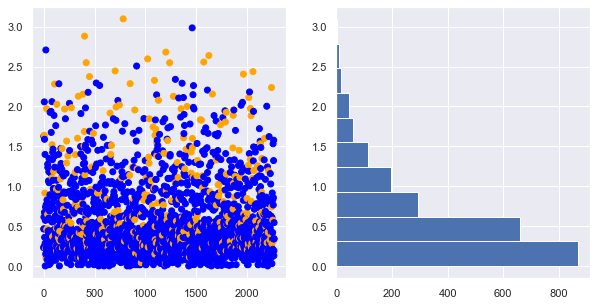

In [430]:
fig, axes = plt.subplots(figsize=(10, 5), ncols=2)
axes[0].scatter(np.arange(proboost.weights.shape[0]), 
                proboost.weights,
                c = np.where(proboost.y_train["cens"], "orange", "blue"))
axes[1].hist(proboost.weights, orientation="horizontal")
plt.show()

In [431]:
tr_pred_surv_proboost = proboost.predict_at_times(X_tr, bins=bins, mode="surv")

pred_surv_proboost = proboost.predict_at_times(X_HO, bins=bins, mode="surv")
#pred_time_proboost = proboost.predict(X_HO, target=cnt.TIME_NAME)
pred_haz_proboost = proboost.predict_at_times(X_HO, bins=bins, mode="hazard")

(9, 2264, 822) (2264, 9)
(9, 1116, 822) (1116, 9)
(9, 1116, 822) (1116, 9)


In [432]:
pred_time_proboost = proboost.predict(X_HO, target=cnt.TIME_NAME)

In [433]:
print("TRAIN PR:", metr.ibs(y_tr, y_tr, tr_pred_surv_proboost, bins, axis=-1))
print("TEST PR:", metr.ibs(y_tr, y_HO, pred_surv_proboost, bins, axis=-1))

TRAIN PR: 0.08648453687013388
TEST PR: 0.14320886124650614


In [434]:
proboost.ibs_means

[0.0,
 0.06714986246762214,
 0.13351556501081263,
 0.19668583149611532,
 0.23764111409452018,
 0.29420620333442055,
 0.36067783412828197,
 0.41600784611230246,
 0.4782140493475392]

In [435]:
pred_time_proboost

array([ 18.18506793,  89.83288152, 430.51851748, ...,  15.51639819,
        40.87725365,  76.8047937 ])

In [436]:
y_HO["time"]

array([  1.,   7., 357., ...,   2.,  14.,  44.])

In [438]:
res = []
weights = None
if proboost.aggreg_func == "obs_wei":
    weights = [np.zeros(X_HO.shape[0])]
for i in range(len(proboost.models)):
    res.append(proboost.models[i].predict(X_HO, target=cnt.TIME_NAME))
    if proboost.aggreg_func == "obs_wei":
        weights.append(proboost.models[i].get_ibs_by_leaf(X_HO))

res = np.array(res)
if proboost.aggreg_func == "obs_wei":
    weights = np.vstack(weights[:-1]).T
    weights = np.cumsum(weights, axis=1)
    weights = norm.cdf((weights - np.array(proboost.ibs_means)) / np.array(proboost.ibs_stds))

In [469]:
weights[7]

array([0.5       , 0.93231822, 0.99993847, 0.99542244, 0.983065  ,
       0.95260141, 0.89306973, 0.83029409, 0.88019199])

In [470]:
res[:, 7]

array([265.222229  , 693.1428833 , 347.2727356 , 409.6000061 ,
       410.875     , 433.        , 273.42855835, 368.5       ,
       365.09091187])

In [461]:
np.sum((res.T*1/weights).T, axis=0) / np.sum(1/weights, axis=1)

array([ 16.32708759,  83.1344909 , 434.85983972, ...,  26.18814325,
        37.4535739 ,  80.27115504])

In [471]:
pred_time_proboost[7]

404.3874271384731

In [468]:
y_HO[7]

(True, 466.)